In [1]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

--2022-08-09 09:26:51--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  4.12MB/s    in 64s     

2022-08-09 09:27:56 (3.70 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]



In [ ]:
!tar -zxvf /content/maps.tar.gz

In [ ]:
%cd /content/maps/val/
!ls

In [8]:
import matplotlib.pyplot as plt
import cv2

/content/maps/val
(600, 1200, 3)


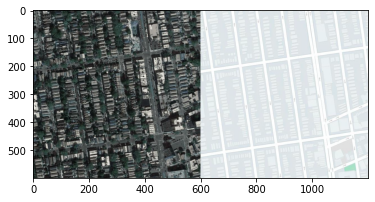

In [16]:
import os
print(os.getcwd())
img = cv2.imread('135.jpg')
print(img.shape)
plt.imshow(img)
plt.show()

In [6]:
### discriminator model
import torch
import torch.nn as nn

class CNNBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode = 'reflect'),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

  def forward(self, x):
    return self.conv(x)

class Discriminator(nn.Module):
  def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels*2, features[0], kernel_size = 4, stride=2, padding=1, padding_mode = 'reflect'),
        nn.LeakyReLU(0.2)
    )

    layers = []
    in_channels = features[0]
    for feature in features[1:]:
      layers.append(
          CNNBlock(in_channels, feature, stride=1 if feature==features[-1] else 2),
      )
      in_channels = feature
    layers.append(
        nn.Conv2d(in_channels, 1,kernel_size=4, stride=1, padding=1, padding_mode = 'reflect')
    )
    self.model = nn.Sequential(*layers)

  def forward(self, x, y):
    x = torch.cat([x, y], dim=1)
    x = self.initial(x)
    x = self.model(x)
    return x

def test():
  from torchsummary import summary
  x = torch.randn(1, 3, 256, 256).to('cuda')
  y = torch.randn(1, 3, 256, 256).to('cuda')
  model = Discriminator()
  preds = model(x, y)
  summary(model, [(3, 256, 256), (3, 256, 256)])
  print(preds.size())

test()

RuntimeError: ignored

In [7]:
import torch
import torch.nn as nn


class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))


def test():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print(preds.shape)


# if __name__ == "__main__":
test()

torch.Size([1, 3, 256, 256])


In [8]:
## config
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN_DIR = "/content/maps/train"
VAL_DIR = "/content/maps/val"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
LAMBDA_GP = 10
NUM_EPOCHS = 500
LOAD_MODEL = False
SAVE_MODEL = False
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"

both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [9]:
## dataset
import numpy as np
# import config
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image


class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:, :600, :]
        target_image = image[:, 600:, :]

        augmentations = both_transform(image=input_image, image0=target_image)
        input_image = augmentations["image"]
        target_image = augmentations["image0"]

        input_image = transform_only_input(image=input_image)["image"]
        target_image = transform_only_mask(image=target_image)["image"]

        return input_image, target_image


# if __name__ == "__main__":
# dataset = MapDataset("/content/maps/train")
# loader = DataLoader(dataset, batch_size=5)
# for x, y in loader:
#     print(x.shape)
#     save_image(x, "x.png")
#     save_image(y, "y.png")
#     import sys

    # sys.exit()

In [11]:
import torch
# import config
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5  # remove normalization#
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5, folder + f"/label_{epoch}.png")
    gen.train()


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr



In [ ]:
import torch
# from utils import save_checkpoint, load_checkpoint, save_some_examples
import torch.nn as nn
import torch.optim as optim
# import config
# from dataset import MapDataset
# from generator_model import Generator
# from discriminator_model import Discriminator
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchvision.utils import save_image

torch.backends.cudnn.benchmark = True


def train_fn(
    disc, gen, loader, opt_disc, opt_gen, l1_loss, bce, g_scaler, d_scaler,
):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generator
        with torch.cuda.amp.autocast():
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )


def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3, features=64).to(DEVICE)
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999),)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = nn.BCEWithLogitsLoss()
    L1_LOSS = nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE,
        )

    train_dataset = MapDataset(root_dir=TRAIN_DIR)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
    )
    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()
    val_dataset = MapDataset(root_dir=VAL_DIR)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

    for epoch in range(NUM_EPOCHS):
        train_fn(
            disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE, g_scaler, d_scaler,
        )

        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

        save_some_examples(gen, val_loader, epoch, folder="evaluation")


# if __name__ == "__main__":
main()

 97%|█████████▋| 67/69 [00:19<00:00,  3.28it/s, D_fake=0.0165, D_real=0.977]